## Q1. Kalman Filter with GPS

With linear position measurement model


### (b) Plot true traj and velocity

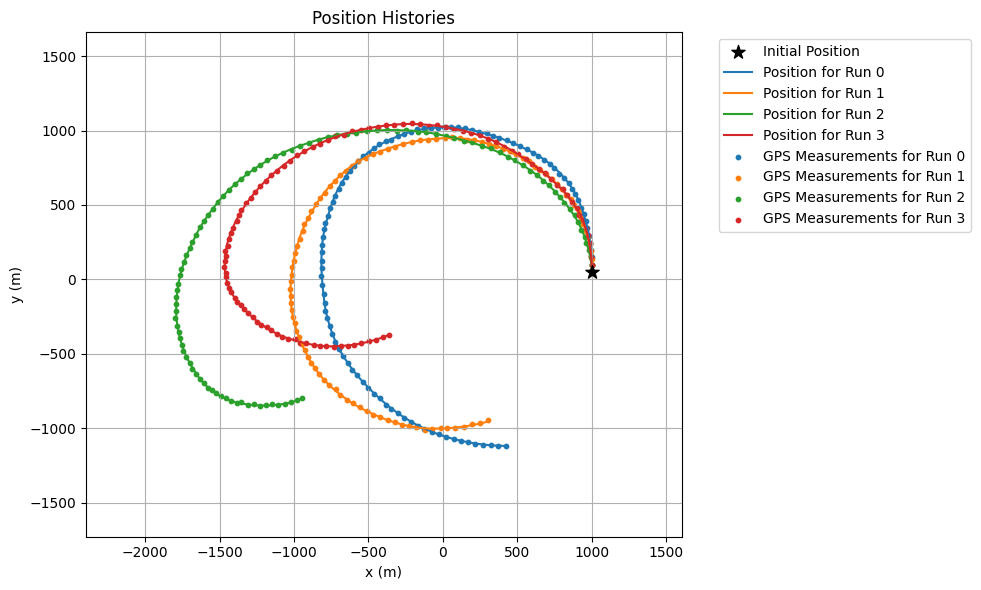

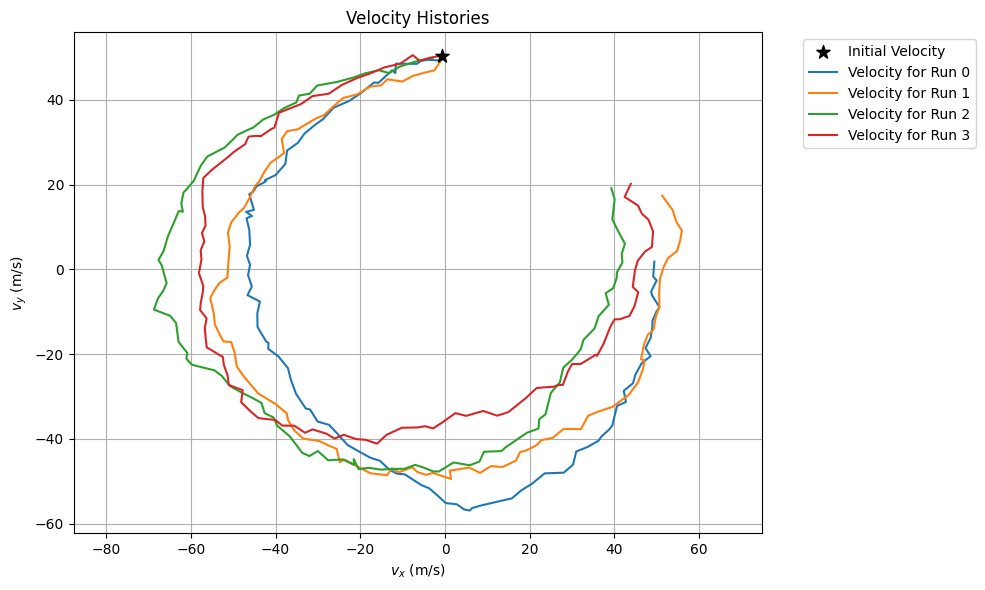

In [14]:
# (b)
import numpy as np
import matplotlib.pyplot as plt
import q1q2_simulator_class as sim

# Define initial state [position p, velocity s]
n_steps = 100
p0 = [1000, 0]
s0 = [0, 50]

# Initialize the simulator
quadrotor = sim.QuadrotorSimulator(sensor="GPS") # defualt noise

# Simulate result for multi-runs
pos_hists, vel_hists, meas_pose_hists, uhists = quadrotor.simulate_multiple_runs(p0=p0, s0=s0, num_t=n_steps, num_runs=4)

# Plot simulated traj and velocity
fig1_b_pos = quadrotor.plot_position_histories(pos_hists, meas_pose_hists)
fig1_b_vel = quadrotor.plot_velocity_histories(vel_hists)

### (c) KF - Position Measurement

In [15]:
mu_0 = np.array([1500, 100, 0, 55])  # 4x1
sigma_0 = np.block([[250000*np.eye(2), np.zeros((2,2))], [np.zeros((2,2)), np.eye(2)]]) # 4x4

# Define matrix
dt = quadrotor.dt
A = np.block([[np.eye(2), dt * np.eye(2)],
            [np.zeros((2,2)), np.eye(2)]]) # (4x4) state transition matrix
B = np.block([[np.zeros((2,2))], [dt*np.eye(2)]]) # (4x2) control-input matrix
C = np.block([np.eye(2), np.zeros((2,2))]) # (4x2) 

# Print matrices
print("State Transition Matrix (A):")
print(A)
print("\nControl-Input Matrix (B):")
print(B)
print("\nObservation Matrix (C):")
print(C)

# Define noise matrix 
Q = np.block([[np.zeros((2,2)), np.zeros((2,2))], [np.zeros((2,2)), quadrotor.q_mat]]) # (4x4) Process noisy on velocity 
R = quadrotor.r_mat

def KF(mu_0, sigma_0, u_arr, y_arr, A, B, C, Q, R):

    # Place Holder
    mu_update = [mu_0] # udpate state mean
    cov_update = [sigma_0] # udpate state cov
    mu_pred = [] # pred state mean
    mu_cov = [] # pred state cov

    for t, (u, y) in enumerate(zip(u_arr, y_arr)):
        # Prediction Step
        # print(u_arr.shape, u.shape)
        mu_bar_next = A @ mu_update[-1] + B @ u # Predict the next state, 4x1
        sigma_bar_next = A @ cov_update[-1] @ A.T + Q  # Predict the next covariance, 4x4

        # Update Step
        K_t_numerator = sigma_bar_next @ C.T # (4x4)(4x2) = (4x2)
        K_t_denominator = C @ sigma_bar_next @ C.T + R # 2x2
        K_t = K_t_numerator @ np.linalg.inv(K_t_denominator) # 4x2

        # observation
        expected_y = C @ mu_bar_next # pass the expected state through the measurement model --> the expected position
        mu_next = mu_bar_next + K_t @ (y - expected_y)  # Update state mean
        sigma_next = (np.eye(4) - K_t @ C) @ sigma_bar_next  # Update state covariance
        
        mu_update.append(mu_next)
        cov_update.append(sigma_next)
        mu_pred.append(mu_bar_next)
        mu_cov.append(sigma_bar_next)
    return np.array(mu_update[1:]), np.array(cov_update[1:]), np.array(mu_pred), np.array(mu_cov)
                    

State Transition Matrix (A):
[[1. 0. 1. 0.]
 [0. 1. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]

Control-Input Matrix (B):
[[0. 0.]
 [0. 0.]
 [1. 0.]
 [0. 1.]]

Observation Matrix (C):
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]]


In [16]:
# plot error ellipse from Pset2
import scipy
from scipy.stats import chi2

def error_ellipse(ax, mu, sig, p=0.95, samples=1000):
    # creat ellipse
    t = np.linspace(0, 2*np.pi, 100)
    circ = np.array([np.cos(t), np.sin(t)]).T
    r = chi2.ppf(p, df=2)
    eta = scipy.linalg.sqrtm(sig) * np.sqrt(r)
    ellipse = circ @ eta + mu

    # Draw
    ax.plot(ellipse[:,0], ellipse[:,1], color='k', alpha=0.2, label="Error")

#### Plot KF (positon)

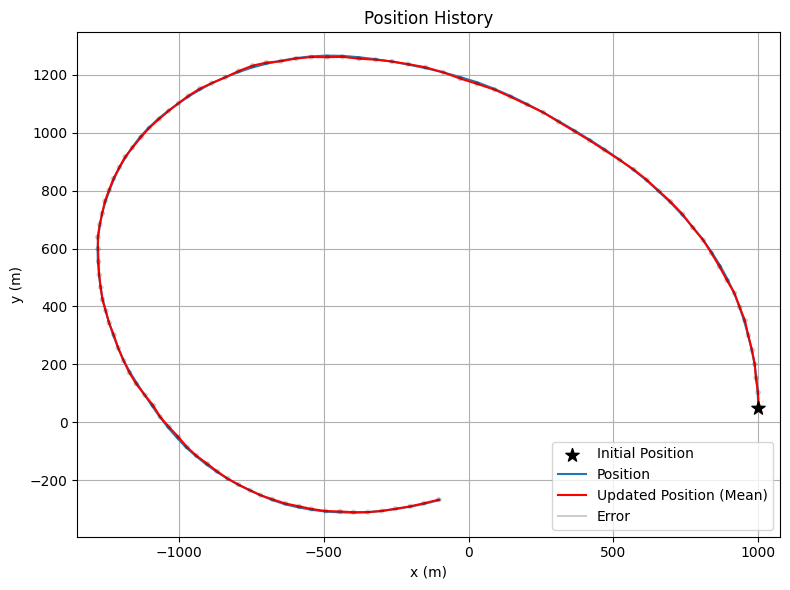

In [17]:
# Simulate result for single run
pos_hist, vel_hist, meas_pose_hist, uhist = quadrotor.simulate(p0=p0, s0=s0, num_t=n_steps)
# Calculate updated and predicted state (mean and cov) using KF
mu_update, cov_update, mu_pred, mu_cov = KF(mu_0=mu_0, sigma_0=sigma_0, u_arr=uhist, y_arr=meas_pose_hist, A=A, B=B, C=C, Q=Q, R=R)

# PLOT result (position)
fig1_c_pos = quadrotor.plot_position_history(pos_hist, show_plot=False) # plot true traj
ax = fig1_c_pos.axes[0]
ax.plot(mu_update[:,0], mu_update[:,1], color='r', label="Updated Position (Mean)") # update traj from prediction

for t in range(mu_update.shape[0]):
    mean = mu_update[t,:2] # mean for pos
    cov = cov_update[t,:2, :2] # cov for pos
    error_ellipse(ax, mean, cov)
    
handles, legends = ax.get_legend_handles_labels()
plt.legend(handles[:4], legends[:4])
plt.show()


#### Plot KF (Velocity)

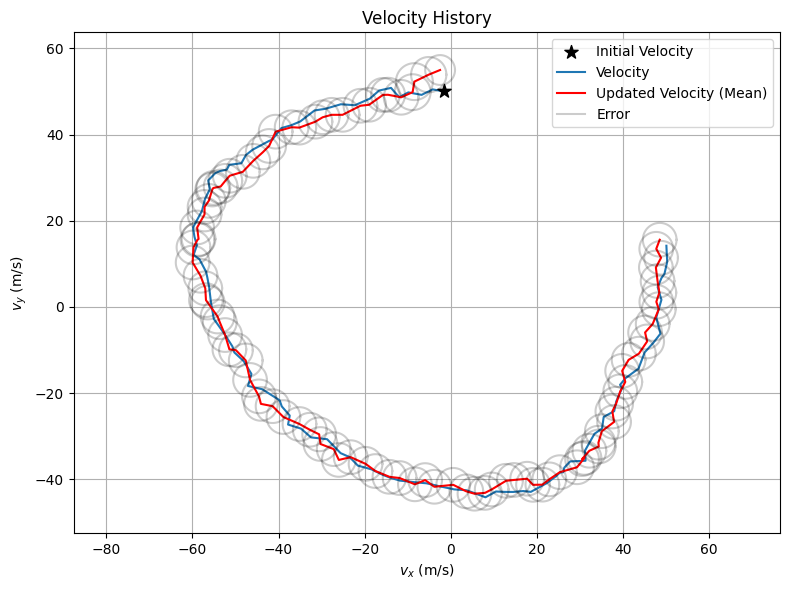

In [18]:
# PLOT result (velocity)
fig1_d_vel = quadrotor.plot_velocity_history(vel_hist, show_plot=False) # plot true traj
ax = fig1_d_vel.axes[0]
ax.plot(mu_update[:,2], mu_update[:,3], color='r', label="Updated Velocity (Mean)") # update traj from prediction

for t in range(mu_update.shape[0]):
    mean = mu_update[t,2:] # mean for vel
    cov = cov_update[t, 2:, 2:] # cov for vel
    error_ellipse(ax, mean, cov)
    
handles, legends = ax.get_legend_handles_labels()
plt.legend(handles[:4], legends[:4])
plt.show()

# Q2. Kalman Filtering with Inertial Systems

with velocity measurement

In [19]:
# Define new state estimation 
mu_0_d = np.array([1000, 0, 0, 50])
sigma_0_d = np.block([[np.eye(2), np.zeros((2,2))], [np.zeros((2,2)), np.eye(2)]])

# Define matrix (A, B, Q, R -- unchange)
C = np.block([np.zeros((2,2)), np.eye(2)]) # (4x2) 

#### Plot (1) True trajectory (2) true velocity and measurement

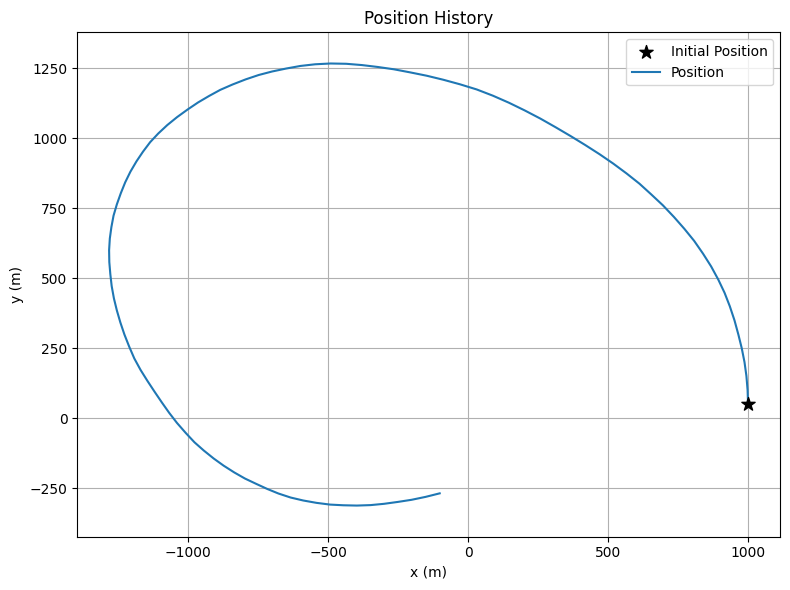

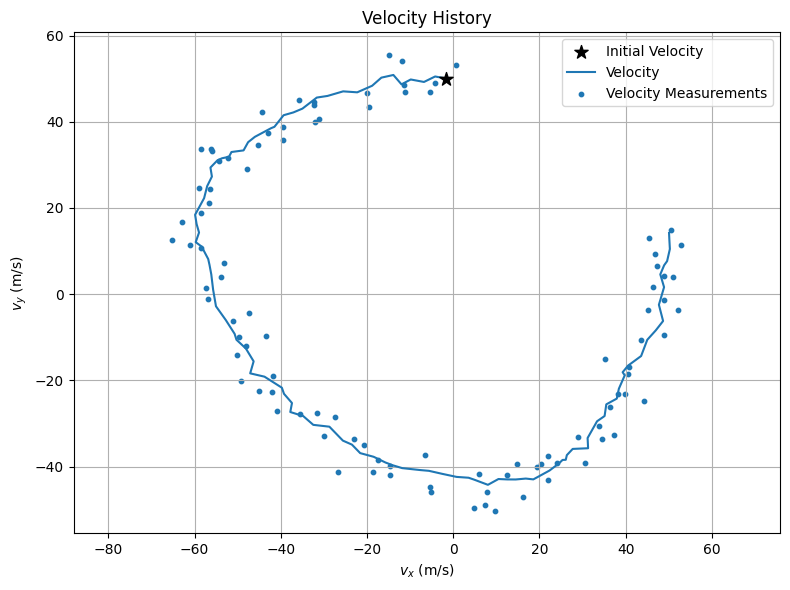

In [20]:
# Initialization
quadrotor = sim.QuadrotorSimulator(sensor="Velocity") # Initialize the simulator
pos_hist, vel_hist, meas_pose_hist, uhist = quadrotor.simulate(p0=p0, s0=s0, num_t=n_steps) # Simulate result for single run

fig = quadrotor.plot_position_history(pos_hist, show_plot=True)
fig = quadrotor.plot_velocity_history(vel_hist, meas_pose_hist, show_plot=True)

#### Plot KF - velocity measurement

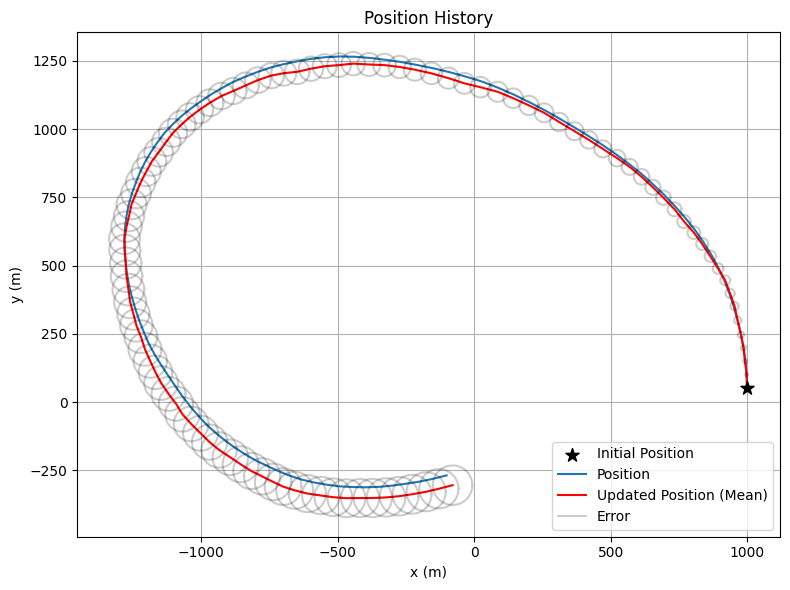

In [21]:
# Calculate updated and predicted state (mean and cov) using KF
mu_update, cov_update, mu_pred, mu_cov = KF(mu_0=mu_0_d, sigma_0=sigma_0_d, u_arr=uhist, y_arr=meas_pose_hist, A=A, B=B, C=C, Q=Q, R=R)

# PLOT result (position)
fig2_pos = quadrotor.plot_position_history(pos_hist, show_plot=False) # plot true traj
ax = fig2_pos.axes[0]
ax.plot(mu_update[:,0], mu_update[:,1], color='r', label="Updated Position (Mean)") # update traj from prediction

for t in range(mu_update.shape[0]):
    mean = mu_update[t,:2] # mean for pos
    cov = cov_update[t,:2, :2] # cov for pos
    error_ellipse(ax, mean, cov)
    
handles, legends = ax.get_legend_handles_labels()
plt.legend(handles[:4], legends[:4])
plt.show()

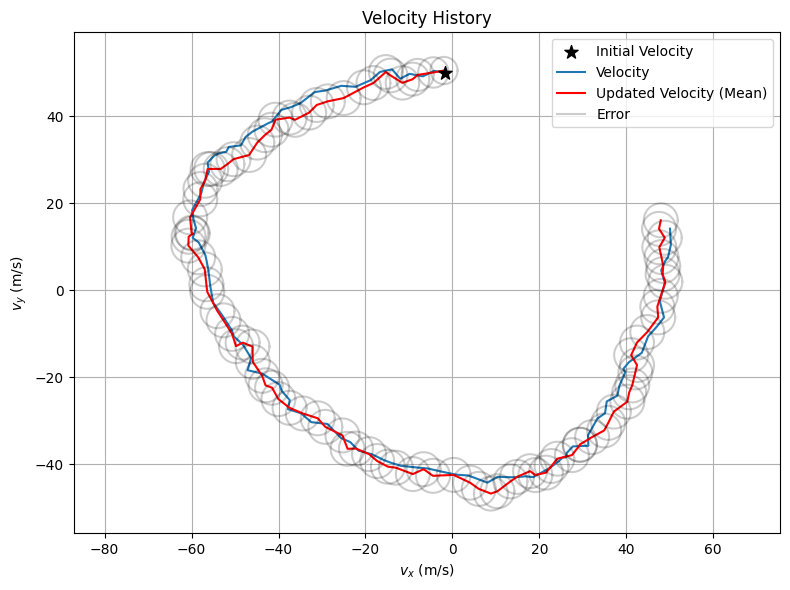

In [22]:
# PLOT result (velocity)
fig2_vel = quadrotor.plot_velocity_history(vel_hist, show_plot=False) # plot true traj
ax = fig2_vel.axes[0]
ax.plot(mu_update[:,2], mu_update[:,3], color='r', label="Updated Velocity (Mean)") # update traj from prediction

for t in range(mu_update.shape[0]):
    mean = mu_update[t,2:] # mean for vel
    cov = cov_update[t, 2:, 2:] # cov for vel
    error_ellipse(ax, mean, cov)
    
handles, legends = ax.get_legend_handles_labels()
plt.legend(handles[:4], legends[:4])
plt.show()